In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore") # suppress warning

np.random.seed(1996)

df = pd.read_csv("dataset/zoo.csv")
df_class = pd.read_csv("dataset/class.csv")

In [34]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Class_Number                       7 non-null      int64 
 1   Number_Of_Animal_Species_In_Class  7 non-null      int64 
 2   Class_Type                         7 non-null      object
 3   Animal_Names                       7 non-null      object
dtypes: int64(2), object(2)
memory usage: 352.0+ bytes


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal_name  101 non-null    object
 1   hair         101 non-null    int64 
 2   feathers     101 non-null    int64 
 3   eggs         101 non-null    int64 
 4   milk         101 non-null    int64 
 5   airborne     101 non-null    int64 
 6   aquatic      101 non-null    int64 
 7   predator     101 non-null    int64 
 8   toothed      101 non-null    int64 
 9   backbone     101 non-null    int64 
 10  breathes     101 non-null    int64 
 11  venomous     101 non-null    int64 
 12  fins         101 non-null    int64 
 13  legs         101 non-null    int64 
 14  tail         101 non-null    int64 
 15  domestic     101 non-null    int64 
 16  catsize      101 non-null    int64 
 17  class_type   101 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 14.3+ KB


Il dataset non presenta elementi nulli, procedo mostrando una matrice di correlazione delle variabile visualizzando la correlazione della variabile una volta sola

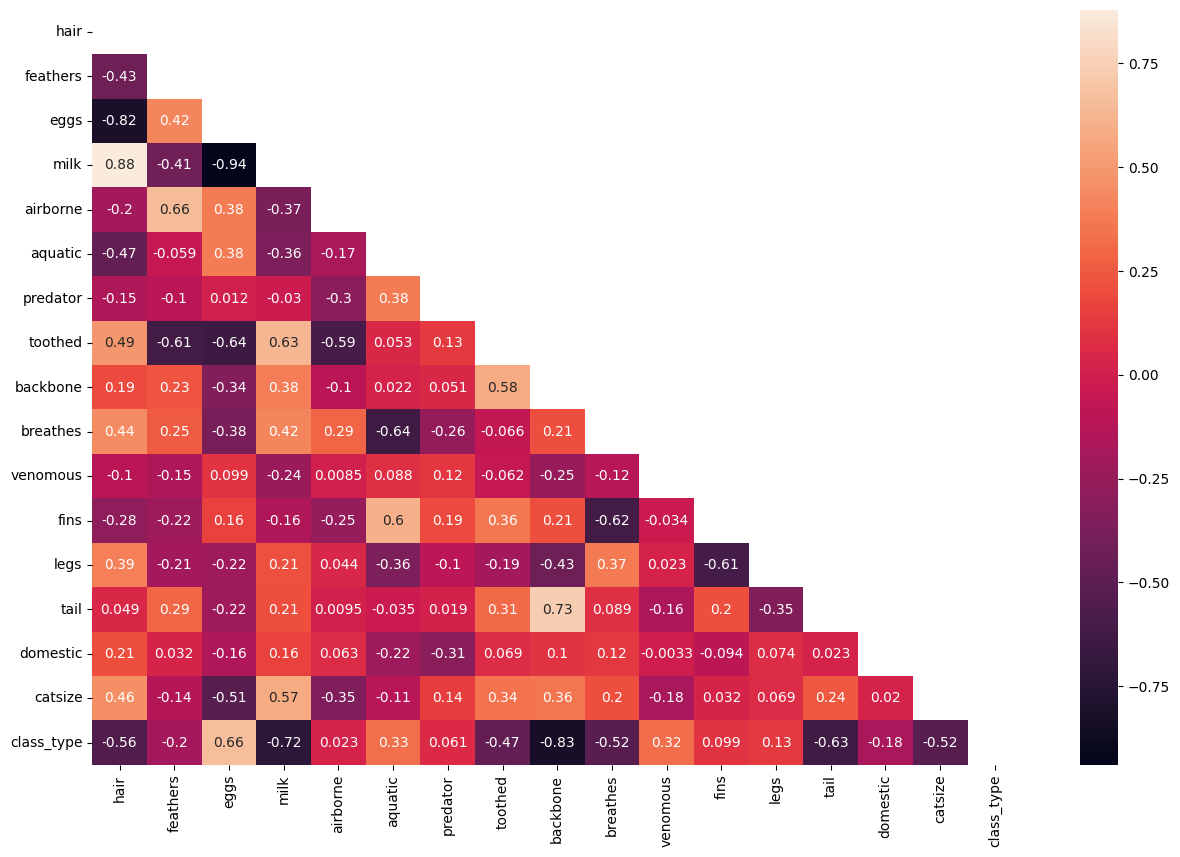

In [36]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':100})
sn.heatmap(df.corr(), annot=True, mask=mask)
plt.show()

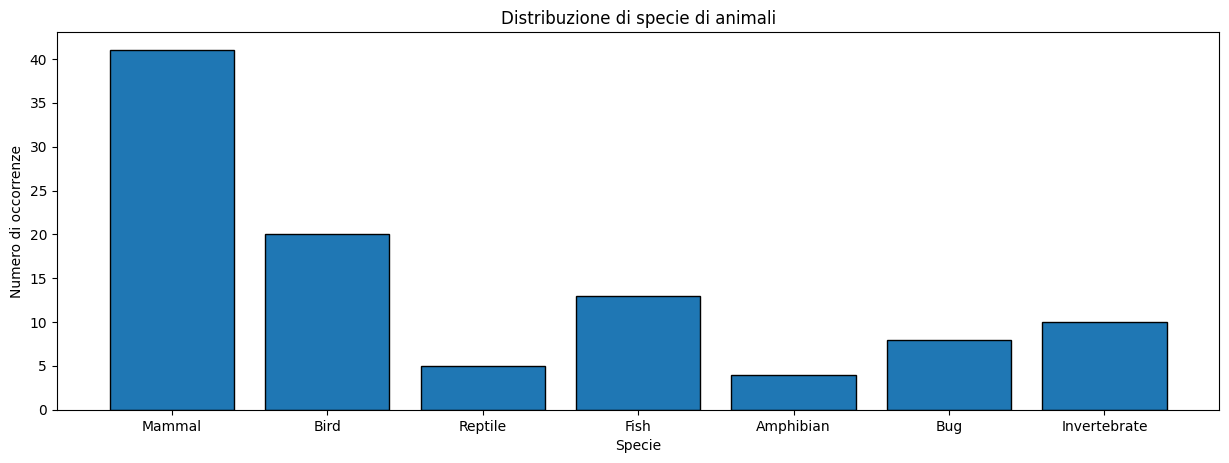

In [37]:
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':100})
plt.title('Distribuzione di specie di animali')
plt.ylabel('Numero di occorrenze')
plt.xlabel('Specie')
plt.bar(df_class.Class_Type, df_class.Number_Of_Animal_Species_In_Class, edgecolor='black')
plt.show()

# deprecata ??
# plt.rcParams.update({'figure.figsize':(25,25), 'figure.dpi':100})
# sn.pairplot(df_zoo)
# plt.show()


In [38]:
# df_training, df_test = train_test_split(df,test_size=0.15)
# print("Numero di campioni totale", len(df))
# print("Numero di campioni di training",len(df_training))
# print("Numero di campioni di test",len(df_test))

# valori di input
X = df.drop(columns=['animal_name','class_type'])
# variabile che voglio predire
y = df['class_type']

PCA - Riduzione della dimensionalità del dataset

In [39]:
from sklearn.decomposition import PCA
# X_reduced because is reduced after PCA decomposition
X_red = PCA().fit_transform(X,y)

print(X_red , type(X_red) , len(X_red), len(X_red[0]))

[[ 1.35102851 -1.05853312  0.31410259 ...  0.22776438  0.05746399
   0.04819587]
 [ 1.30663411 -1.20834446 -0.28940524 ... -0.00645594 -0.003654
  -0.031995  ]
 [-3.13165517  0.25220045  0.92941871 ...  0.08950714 -0.00613439
   0.01599322]
 ...
 [ 1.27729583 -1.22574951  0.12623911 ... -0.02718482 -0.01747613
  -0.01449933]
 [-2.62160156  0.84538463 -0.44020121 ... -0.19388607 -0.11100554
  -0.00721392]
 [-0.87003814  1.00958479 -1.3082922  ...  0.11598219  0.06519472
  -0.00965952]] <class 'numpy.ndarray'> 101 16


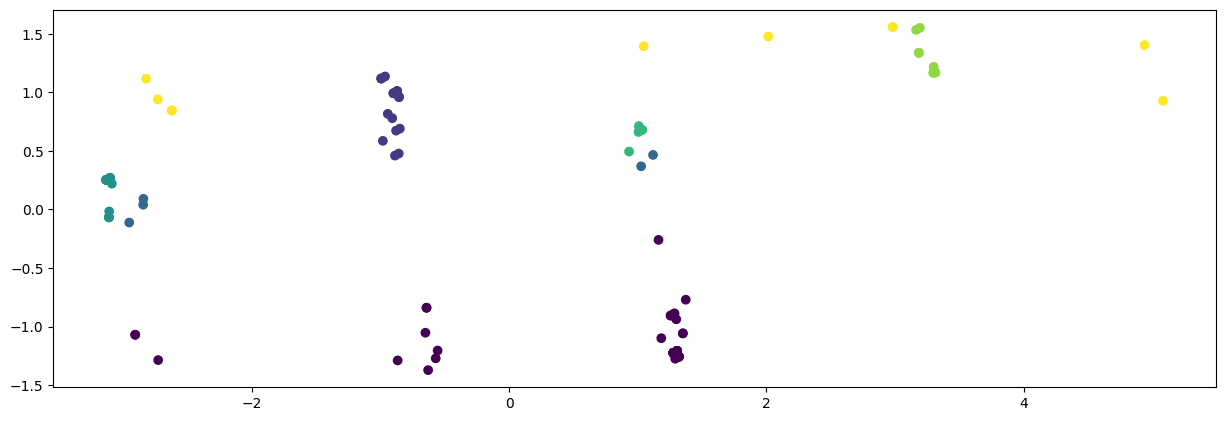

In [40]:
plt.scatter(x=X_red[:,0], y=X_red[:,1], c=df['class_type'])
plt.show()

Test di vari modelli e relativa implementazione

Per prima cosa mi creo un dataset di training e test univocamente

In [41]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.25)

print("Dimensione training set %d, dimensione test set %d" % (len(X_train), len(X_test)))


Dimensione training set 75, dimensione test set 26


Linear regression

(train) accuracy score: 0.9820537842768811
(test) accuracy score: 0.971111893096525


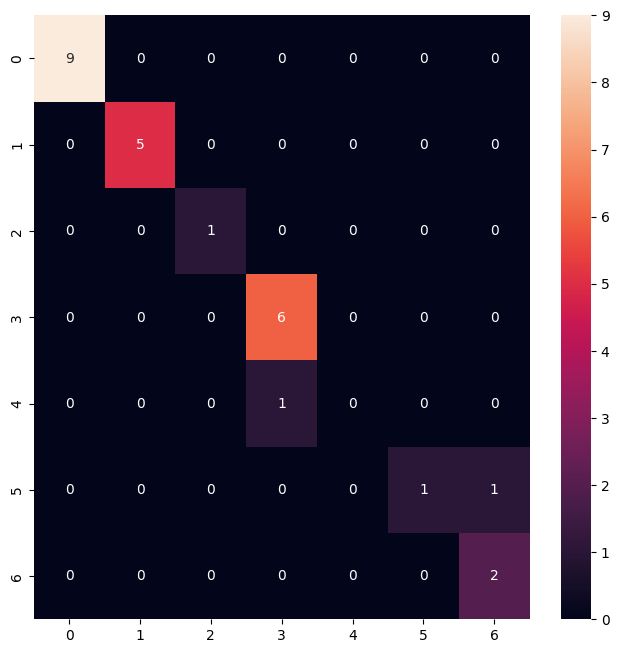

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print(f"(train) accuracy score: {lr_model.score(X_train, y_train)}")
y_pred = lr_model.predict(X_test)
lr_score = lr_model.score(X_test, y_test)
print(f"(test) accuracy score: {lr_score}")
y_pred = np.round(y_pred).astype(int)

plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
sn.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True)
plt.show()

Decision trees

(train) accuracy score: 0.9466666666666667
(test) accuracy score: 0.9230769230769231


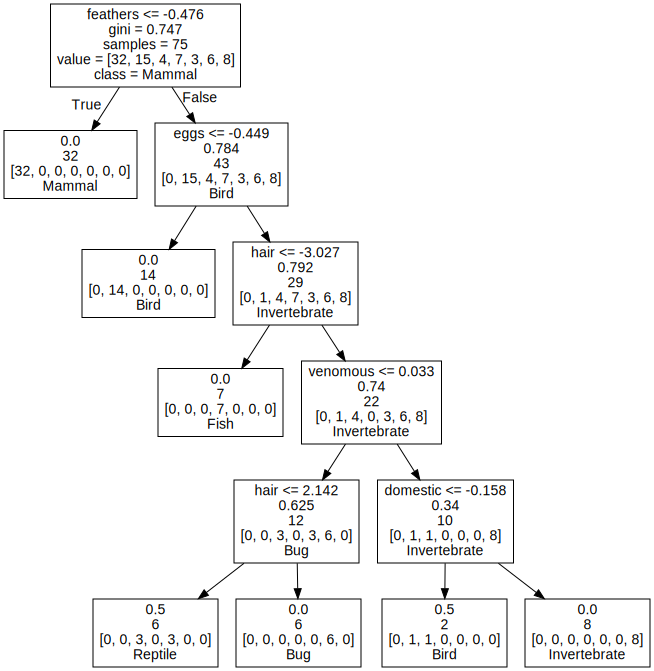

In [43]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#limitiamo la profondità massima dell'albero per poterlo visualizzare in seguito
dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train, y_train)
print(f"(train) accuracy score: {dt_model.score(X_train, y_train)}")
dt_score = dt_model.score(X_test, y_test)
print(f"(test) accuracy score: {dt_score}")

#specifichiamo, tra le altre cose, il nomi delle feature e quelli delle classi

dot_data = tree.export_graphviz(dt_model, out_file=None, feature_names=X.columns.values, class_names=df_class.Class_Type.values, rotate=False, label='root')
graph = graphviz.Source(dot_data)
graph

Random forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=3, n_jobs=-1)

rf_model.fit(X_train, y_train)
print(f"(train) accuracy score: {rf_model.score(X_train, y_train)}")
rf_score = rf_model.score(X_test, y_test)
print(f"(test) accuracy score: {rf_score}")

(train) accuracy score: 0.9866666666666667
(test) accuracy score: 0.9615384615384616


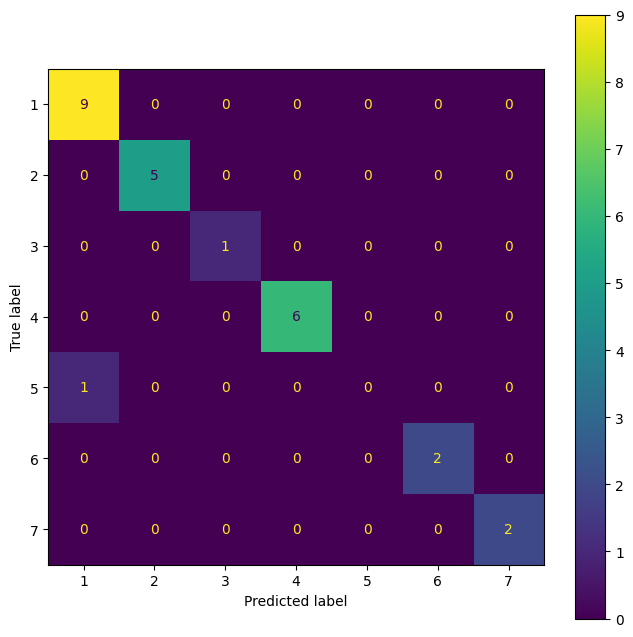

In [45]:
plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
plot_confusion_matrix(rf_model, X_test, y_test.values)
plt.show()


# inserire eventuale test per per controllare i margini

KN Neighbor

In [46]:
from sklearn.neighbors import KNeighborsClassifier


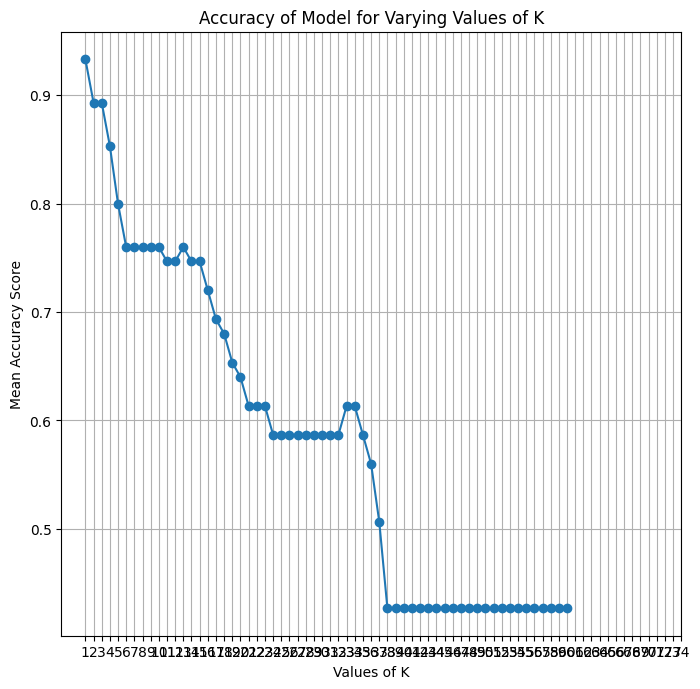

In [47]:
# Get score for different values of n
k_list = np.arange(1, len(X_train))
mean_scores = []
accuracy_list = []
error_rate = []

for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    score = cross_val_score(knn,X_train, y_train)
    mean_scores.append(np.mean(score))
    error_rate.append(np.mean(pred_i != y_test))

# Plot n values and average accuracy scores
plt.plot(k_list,mean_scores, marker='o')

plt.rcParams.update({'figure.figsize':(30, 8), 'figure.dpi':100})
# Added titles and adjust dimensions
plt.title('Accuracy of Model for Varying Values of K')
plt.xlabel("Values of K")
plt.ylabel("Mean Accuracy Score")
plt.xticks(k_list)
plt.grid()
plt.show()

In [48]:
from sklearn.model_selection import GridSearchCV
#definiamo la griglia di parametri.
param_grid = [ {'n_neighbors':range(1,50)}]
#definiamo l'oggetto Grid Search
gs = GridSearchCV(KNeighborsClassifier(), param_grid)
#avviamo la ricerca.
gs.fit(X_train, y_train)
best_knn = gs.best_estimator_
print("Migliore valore di K trovato utilizzando solo il training set: %d" % best_knn.n_neighbors)

Migliore valore di K trovato utilizzando solo il training set: 1


In [49]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train,y_train)
print(f"(train) accuracy score: {knn_model.score(X_train, y_train)}")
knn_score = knn_model.score(X_test, y_test)
print(f"(test) accuracy score: {knn_score}")

(train) accuracy score: 1.0
(test) accuracy score: 1.0


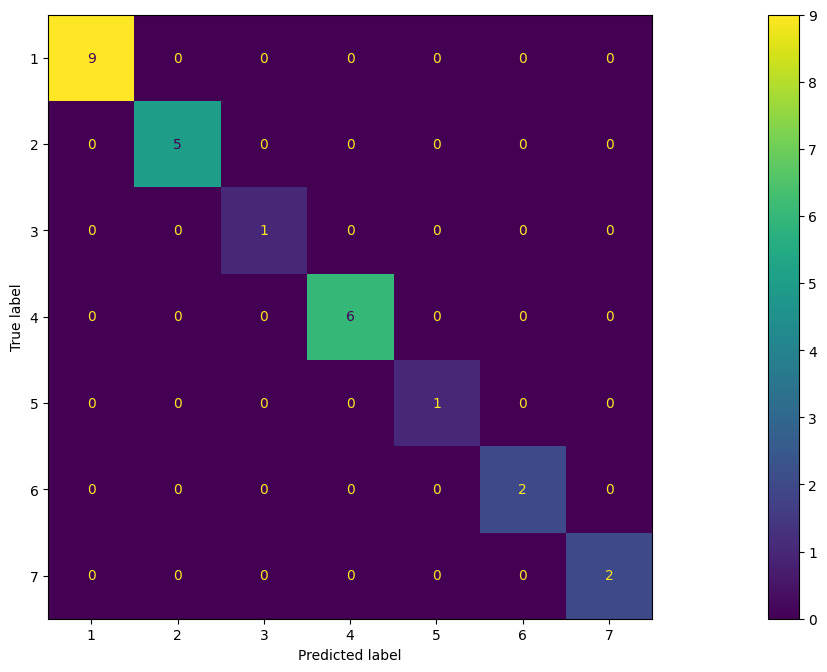

In [50]:
plot_confusion_matrix(knn_model, X_test, y_test.values)
plt.show()

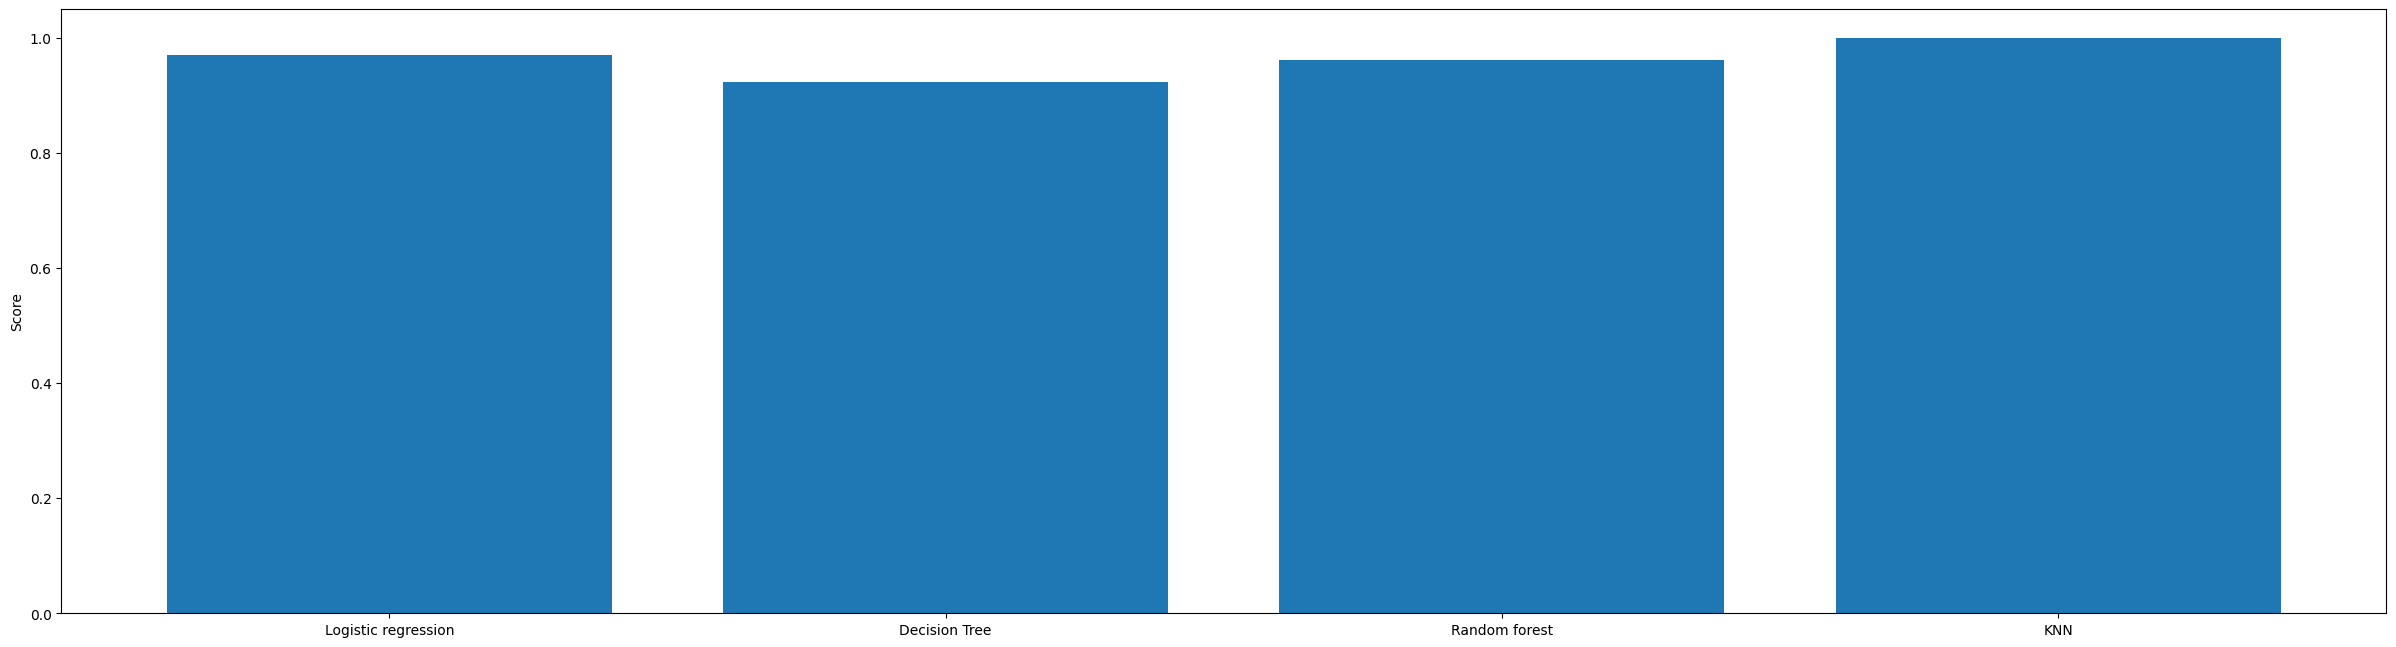

In [51]:
x = np.arange(4)

scores = np.array([ lr_score, dt_score, rf_score, knn_score ])

plt.bar(x, scores)
plt.xticks(x, ('Logistic regression', 'Decision Tree', 'Random forest', 'KNN'))
plt.ylabel(ylabel='Score')
plt.show()